In [ ]:
# Loading datasets and libraries

In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from numpy import random

In [148]:
df = pd.read_csv('Train_set.csv')

In [ ]:
# Preproccesing

In [150]:
# Simple idea of putting 0
df.fillna(0, inplace = True)

In [151]:
# Separate the ID and class columns from the input features
ids = df['ID']
y = df['Class']
y = np.array(y)
X = df.drop(['ID', 'Class'], axis=1)

# Standardize the input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [154]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

In [272]:
class Attention(nn.Module):

    def __init__(self, dimx):
        
      super().__init__()
      self.dimx = dimx
      self.Q = nn.Linear(1, dimx) # 1 for dimension of x - one value
      self.K = nn.Linear(1, dimx)
      self.V = nn.Linear(1, dimx)
      self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
      queries = self.Q(x)
      keys = self.K(x)
      values = self.V(x)
      preweights = torch.matmul(torch.transpose(keys,0,1), queries) / np.sqrt(self.dimx)
      weights = self.softmax(preweights)
      embeddings = torch.matmul(values, weights)
      return embeddings

In [282]:
class RNN(nn.Module):
    def __init__(self, dimx, output_size, hidden_dim, n_layers = 1,drop=0.5):
        
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dimx = dimx
        # Attention
        self.attention = Attention(dimx)
        # LSTM layer
        self.rnn = nn.LSTM(dimx, hidden_dim, n_layers)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size) 
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Capa dropout 
        self.dropout = nn.Dropout(p=drop)

    def forward(self, x):

        '''
        - x: Sequences of word embeddings. Dimensions (#no batch, max_l, word_embedding_size)
        - lengths: The real length of each sequence, excluding the junk # tokens! You use this to know what
          RNN state you should use to classify
        '''
        #x = x.reshape(x.size(0))
        x = np.trim_zeros(x, 'b')
        x = torch.Tensor(x).view(-1,1)
        x = x.to(torch.float32)
        x = self.attention.forward(x)
        # Compute the RNN output (sequence of states for the whole input)
        _, last_state =  self.rnn(x)
        last_state = last_state[0]
        last_state_drop = self.dropout(last_state)
        x_out = self.fc1(last_state_drop)
        # We classify using such tensor (don't forget the dropout!)
        output = self.logsoftmax(x_out)
        return output

In [313]:
class RNN_with_train(RNN):
    
    def __init__(self,dimx, output_size, hidden_dim, n_layers,drop=0.0,batch_size=5000,lr=0.0005,saved_files='./saved_models/RNN_sentiment_analysis'):
        
        super().__init__(dimx, output_size, hidden_dim, n_layers,drop)  
        
        self.lr = lr # Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer
        
        self.criterion = nn.NLLLoss()               
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = [] 
        
        self.batch_size = batch_size
        
        self.saved_files = saved_files
            
        
    def trainloop(self, X_train, X_val, Y, Y_val,epochs=100,print_every=5):
        
        self.print_every = print_every
        self.epochs=epochs
        
        # Optimization Loop

        #labels = torch.Tensor(Y).type(torch.LongTensor) # Training labels
        
        #labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Validation labels
        
        ### WE ARE HERE
        for e in range(int(self.epochs)):

          for b in range(int(self.batch_size)):
            
            self.train() # Activate dropout
  
            # Random data sample, we even out class imbalances during training!
            #class_number = random.randint(5) # label
            class_number = np.random.choice(5, 1, p=[0.4, 0.15, 0.15, 0.15, 0.15])[0]
            idx = random.choice(np.nonzero(Y == class_number)[0]) # choose element to train given a label
            
            running_loss = 0.
            self.optim.zero_grad() 
            x = X_train[idx,:]
            out = self.forward(x)
            label = torch.Tensor([class_number]).type(torch.LongTensor)
            loss = self.criterion(out,label)
            running_loss += loss.item()
            loss.backward()
            # Gradient clipping
            nn.utils.clip_grad_norm_(self.parameters(), 2.0)
            # SGD steps
            self.optim.step()
        
          self.loss_during_training.append(running_loss/self.batch_size)
            
        # We save model parameters  
          torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')
            
# REAPEAT for valid
          with torch.no_grad(): 
              
            # set model to evaluation mode
            self.eval()
            running_loss = 0.

            for b in range(int(self.batch_size)):
  
              class_number = random.randint(5) # label
              idx = random.choice(np.nonzero(Y_val == class_number)[0]) # choose element to train given a label
              running_loss = 0.
              x = X_val[idx,:]
              out = self.forward(x)
              label = torch.Tensor([class_number]).type(torch.LongTensor)
              loss = self.criterion(out,label)
              running_loss += loss.item()

          self.valid_loss_during_training.append(running_loss/self.batch_size)

        if(e % self.print_every == 0): 

          print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")

In [314]:
rnn = RNN_with_train(10,5,8,1,0.3, batch_size = 50000) # 50 000 is half the data set
rnn.trainloop(X_train, X_val, y_train, y_val,epochs=30) # idk how many epochs

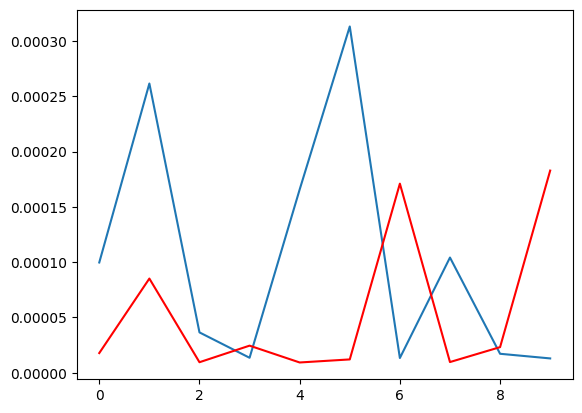

In [315]:
plt.plot(rnn.valid_loss_during_training)
plt.plot(rnn.loss_during_training, color = "red")

In [317]:
df2 = pd.read_csv('Test_set.csv')
df2.fillna(0, inplace = True)
# Separate the ID and class columns from the input features
ids = df2['ID']
X_test = df2.drop(['ID'], axis=1)

# Standardize the input features
#X_test = scaler.transform(X_test)
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
pred_classes = [torch.argmax(rnn.forward(X_test[k,:])) for k in range(X_test.shape[0])]
pred_classes = np.array(pred_classes)

# Create a new pandas DataFrame with the predicted classes and an ID column (if necessary)
ids = np.arange(len(pred_classes))
df = pd.DataFrame({'ID': ids, 'Pred_Class': pred_classes})

# Save the DataFrame as a CSV file
df.to_csv('sub_29-04.csv', index=False)

# 0 class
sum(pred_classes ==0)